In [2]:
%load_ext autoreload
%autoreload 2
%aimport mcfost
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
from numpy import unravel_index
import astropy.units as unit
import pysynphot
import os
from sh import gunzip

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
main_dir='/Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/HLC_band_analog/'
dust='Astrosil/'
file_dir=main_dir+dust


In [11]:
par = mcfost.Paramfile(file_dir+'eps_eri_su.para')
print(par)

3.0                       mcfost version

#Number of photon packages
  1e+05                   nbr_photons_eq_th  : T computation
  10000                   nbr_photons_lambda : SED computation
  1e+06                   nbr_photons_image : images computation

#Wavelength
  150 0.1   3000          n_lambda, lambda_min, lambda_max [microns]
  T T T                   compute temperature?, compute sed?, use default wavelength grid ?
  IMLup.lambda           wavelength file (if previous parameter is F)
  T T                     separation of different contributions?, stokes parameters?

#Grid geometry and size
  1                       1 = cylindrical, 2 = spherical, 3 = Voronoi tesselation (this is in beta, please ask Christophe)
  100  70  1 20           n_rad (log distribution), nz (or n_theta), n_az, n_rad_in

#Maps
  256 256  17.9        grid (nx,ny), size [AU]
  34.0  34.0   1 F    RT: imin, imax, n_incl, centered ?
  0.0   0.0    1    RT: az_min, az_max, n_az
  3.20                   

In [ ]:
#wavelngths for HLC: 0.547,0.557,0.567,0.575,0.583,0.593,0.603

In [12]:
res = mcfost.run_one_file(file_dir+'eps_eri_su.para', wavelengths=[0.575], move_to_subdir=False)

mcfost    : INFO     Running MCFOST for: /Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/HLC_band_analog/Astrosil/eps_eri_su.para
mcfost    : INFO     Computing SED for /Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/HLC_band_analog/Astrosil/eps_eri_su.para
mcfost    : INFO     SED results written to /Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/HLC_band_analog/Astrosil/data_th
mcfost    : INFO     Computing image at 0.575 microns for /Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/HLC_band_analog/Astrosil/eps_eri_su.para
mcfost    : INFO     Calculation complete.


In [13]:
model_34 = mcfost.ModelResults(file_dir)
print(model_34)
print(list(model_34._wavelengths_lookup.values()))
model_34.describe()

<MCFOST ModelResults in directory '/Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/HLC_band_analog/Astrosil'>
['0.583', '0.547', '0.557', '0.593', '0.567', '0.575', '0.603']
Model results in /Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/HLC_band_analog/Astrosil for eps_eri_su.para
    Model has 1 inclinations from 34.00000000000001 to 34.00000000000001
    SED computed from 0.1 - 3000.0 microns using 150 wavelengths
    Images computed for 7 wavelengths: [0.583 0.547 0.557 0.593 0.567 0.575 0.603] micron
    Dust scattering properties have been saved to disk for that model grain population.


In [14]:
inc34=model_34.images['0.575']

In [15]:
px=256
py=256
psf_scale=0.02182 ##arcsecs/pixel
xpix=(np.arange (-px/2, px/2, 1))*psf_scale
ypix=(np.arange (-px/2, px/2, 1))*psf_scale
sq_as_per_pix=psf_scale**2
c=2.99792*10**14
lam=0.575 #in microns#
jy=10**26

In [16]:
sst_34=np.reshape(inc34.data[5,0],(px,py))
sst_34_jy=(sst_34/c)*(lam**2)*jy
np.max(sst_34_jy)

3.591544093390984e-07

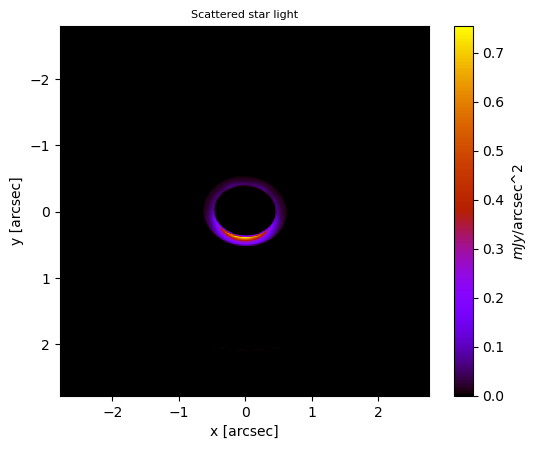

In [19]:
fig=plt.figure(dpi=100)
ax2=plt.subplot(111)
im2=ax2.imshow(sst_34_jy.astype(np.float64)/sq_as_per_pix*1000,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Scattered star light',fontsize=8)
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$mJy$/arcsec^2")

In [20]:
#IR Excess
filename=file_dir+'data_th/sed_rt.fits.gz'
gunzip(filename)
mb=fits.open(file_dir+'data_th/sed_rt.fits')
wavb=mb[1].data
mb_flux=mb[0].data[0]
modelb = pysynphot.ArraySpectrum(wavb, mb_flux.flatten(), name='model_b-spectra',fluxunits='flam',waveunits='microns')
#Star Spectra
star = fits.open(file_dir+'data_th/sed_rt.fits')
wav=star[1].data
star_f=star[0].data[1]
sp = pysynphot.ArraySpectrum(wav, star_f.flatten(), name='Star-spectra',fluxunits='flam',waveunits='microns')

sh.command: INFO     <Command "/usr/bin/gunzip '/Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/HLC_band_analog/Astrosil/data_th/sed_rt.fits.gz'", pid 55196>: process started


In [21]:
obsflux_dir='/Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-models/Final_Models/'
b5sed=np.genfromtxt(obsflux_dir+"backman_fig_5.csv",delimiter=",")
b5sedinset=np.genfromtxt(obsflux_dir+"backman_fig_5_inset.csv",delimiter=",")

In [22]:
#Observed flux-Kate Su
obs_ir=np.genfromtxt(obsflux_dir+"EPSERI_wholeSED_measurements.csv",delimiter=",")
obs_wav=obs_ir[5:24,0]
obs_irex=obs_ir[5:24,3]/1000
obs_irerr=obs_ir[5:24,2]/1000

In [23]:
#irs_measurements
irs_file=np.genfromtxt(obsflux_dir+"EPSERI_IRE_IRS_measurements.csv",delimiter=",")
wav=irs_file[:,0]
irs=irs_file[:,1]/1000
irs_err=irs_file[:,2]/1000

In [24]:
c=2.99792*10**14
mb_jy=10**26*modelb.flux*modelb.wave/c
st_jy=10**26*sp.flux*sp.wave/c
Irb=mb_jy-st_jy

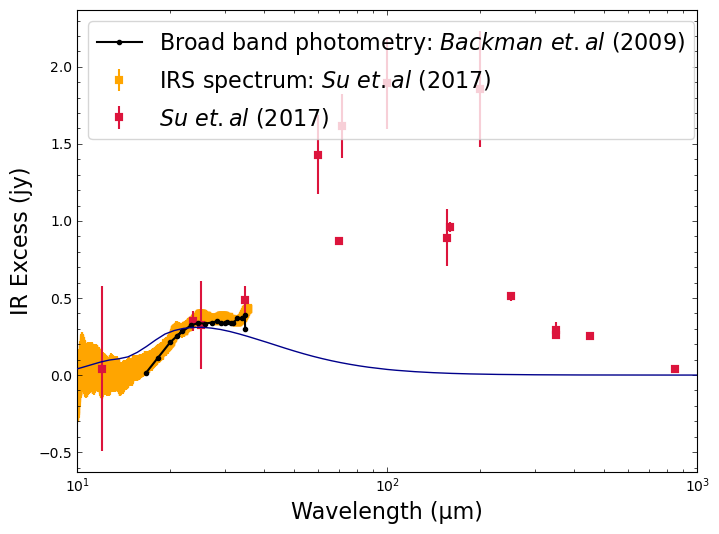

In [36]:
fig=plt.figure(figsize=(8,6))
ax2=fig.add_subplot(111)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', width=0.5)
ax2.semilogx(modelb.wave,Irb,ls='solid', color='darkblue',linewidth=1,zorder=10)
ax2.semilogx(b5sedinset[:,0],b5sedinset[:,1],".-",label="Broad band photometry: $Backman~et.al~(2009)$",color="black",zorder=5)
ax2.semilogx(wav,irs,ls='None',color='orange',zorder=0)
ax2.errorbar(wav,irs,yerr=irs_err,ls='None',marker='s',ms=3, mew=3,label="IRS spectrum: $Su~et.al~(2017)$",mfc='orange',mec='orange',ecolor='orange',zorder=0)
ax2.errorbar(obs_wav,obs_irex,yerr=obs_irerr,ls='None',ms=3, mew=3,marker='s',mfc='crimson',mec='crimson', ecolor='crimson',label="$Su~et.al~(2017)$")
ax2.set_xlim([10,1000])
ax2.set_xlabel('Wavelength (\u03BCm)',fontsize=16)
ax2.set_ylabel('IR Excess (jy)',fontsize=16)
ax2.legend(loc='upper left',fontsize=16)

In [26]:
#Polarization of the disk
I=np.reshape(inc34.data[0,0],(px,py))
Q=np.reshape(inc34.data[1,0],(px,py))
U=np.reshape(inc34.data[2,0],(px,py))
V=np.reshape(inc34.data[3,0],(px,py))
dst=np.reshape(inc34.data[4,0],(px,py))
sst=np.reshape(inc34.data[5,0],(px,py))
dth=np.reshape(inc34.data[6,0],(px,py))
sth=np.reshape(inc34.data[7,0],(px,py))

In [27]:
I_jy=(I/c)*(lam**2)*jy
Q_jy=(Q/c)*(lam**2)*jy
U_jy=(U/c)*(lam**2)*jy
V_jy=(V/c)*(lam**2)*jy
sst_jy=(sst/c)*(lam**2)*jy

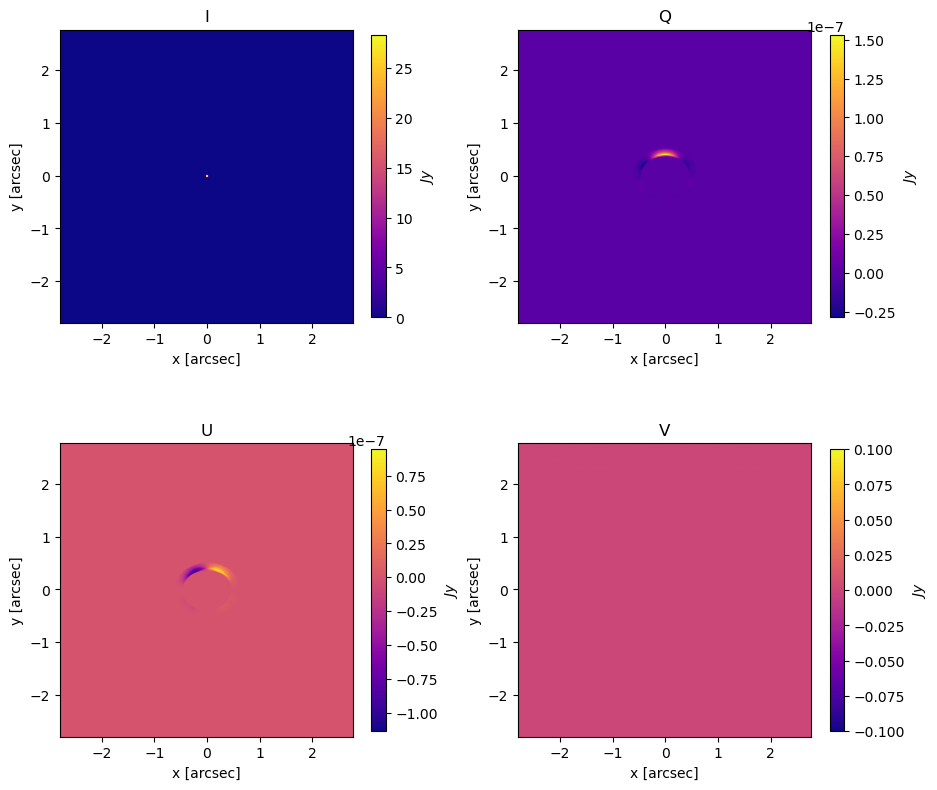

In [32]:
fig = plt.figure(figsize=(10, 10))
ax1=fig.add_subplot(221)
im1=ax1.imshow(I_jy.astype(np.float64),cmap='plasma',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax1.set_ylabel('y [arcsec]')
ax1.set_xlabel('x [arcsec]')
ax1.set_title('I')
cb = fig.colorbar(im1,orientation='vertical',shrink=0.75)
cb.set_label("$Jy$")
ax1.grid(False)

ax2=fig.add_subplot(222)
im2=ax2.imshow(Q_jy.astype(np.float64),cmap='plasma',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Q')
cb = fig.colorbar(im2,orientation='vertical',shrink=0.75)
cb.set_label("$Jy$")
ax2.grid(False)

ax3=fig.add_subplot(223)
im3=ax3.imshow(U_jy.astype(np.float64),cmap='plasma',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax3.set_ylabel('y [arcsec]')
ax3.set_xlabel('x [arcsec]')
ax3.set_title('U')
cb = fig.colorbar(im3,orientation='vertical',shrink=0.75)
cb.set_label("$Jy$")
ax3.grid(False)

ax4=fig.add_subplot(224)
im4=ax4.imshow(V_jy.astype(np.float64),cmap='plasma',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax4.set_ylabel('y [arcsec]')
ax4.set_xlabel('x [arcsec]')
ax4.set_title('V')
cb = fig.colorbar(im4,orientation='vertical',shrink=0.75)
cb.set_label("$Jy$")
ax4.grid(False)
fig.subplots_adjust(hspace=0.1, wspace=0.25, top=0.9, right=0.95)